In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import math
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
%matplotlib inline


# Задача.
### Разработать и обучить модель на основе метаданных поведения пользователя в игре и его итоговой экспертной оценки. Прогнозировать оценки участникам симуляции без привлечения экспертов.

In [ ]:
![jupyter](promo.png)

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

In [3]:
pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())

decision_id
user_id decision_id             
10001   25                     8
        26                     8
        27                     8
        31                     3
        32                     3
...                          ...
10973   304                    1
        306                    1
        344                    1
        386                    1
        427                    1

[44663 rows x 1 columns]

In [4]:
len(df_user['decision_id'].unique())

343

## Рассмотрим датасет по ближе

In [5]:
df_train.shape


(680, 5)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [7]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [8]:
df_user.shape

(60228, 3)

In [9]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [10]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [11]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

# Добавление новых фич

In [12]:
user_com=pd.read_csv('user.csv')
user_com=user_com[user_com.user_id.map(lambda x:x in df_train.id.values)]
user_com

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
3,10600,1908,262
4,10112,1592,219
5,10610,1446,202
...,...,...,...
965,10335,1452,204
967,10777,1394,194
968,10205,1826,249
969,10325,1628,231


In [13]:
user_score=pd.read_csv('team_point.csv')
user_score=user_score[user_score.team_id.map(lambda x:x in user_com.team_id.values)]
user_score

,team_id,category_id,period,score,place
3,1688,4,0,27,4
4,1592,4,2,21,5
5,1344,5,0,8,6
7,1460,2,2,-29,6
9,1848,3,1,62,5
...,...,...,...,...,...
10970,1540,2,2,-48,6
10974,1690,6,2,182,2
10976,1586,5,1,12,3
10978,1764,4,0,27,6


In [14]:
place=pd.DataFrame(user_score.groupby('team_id')['place'].sum()).reset_index()
place

,team_id,place
0,1248,41
1,1252,102
2,1254,127
3,1256,125
4,1258,129
...,...,...
205,1918,115
206,1920,115
207,1922,122
208,1924,116


In [15]:
score=pd.DataFrame(user_score.groupby('team_id')['score'].sum()).reset_index()
score

,team_id,score
0,1248,2698
1,1252,1312
2,1254,1188
3,1256,1504
4,1258,1352
...,...,...
205,1918,1498
206,1920,1434
207,1922,1698
208,1924,1874


In [16]:
score_palace=place.merge(score)
score_palace

,team_id,place,score
0,1248,41,2698
1,1252,102,1312
2,1254,127,1188
3,1256,125,1504
4,1258,129,1352
...,...,...,...
205,1918,115,1498
206,1920,115,1434
207,1922,122,1698
208,1924,116,1874


In [17]:
user_com=user_com.merge(score_palace)
user_com

,user_id,team_id,game_id,place,score
0,10189,1664,235,105,1584
1,10565,1664,235,105,1584
2,10295,1664,235,105,1584
3,10018,1690,237,76,1774
4,10400,1690,237,76,1774
...,...,...,...,...,...
675,10421,1732,241,110,1752
676,10623,1732,241,110,1752
677,10057,1782,245,88,1702
678,10187,1630,231,89,2034


In [18]:
user_com = user_com.rename(columns={'user_id': 'id'})

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

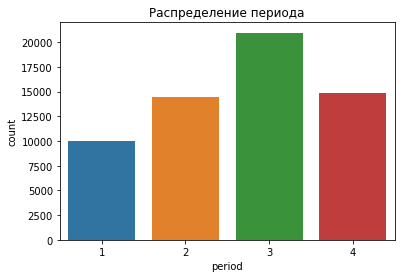

In [19]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

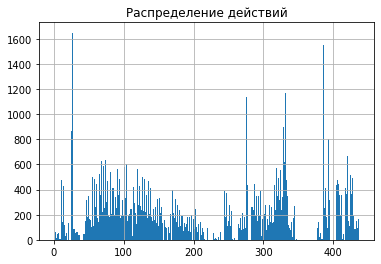

In [20]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [21]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]
df_user_train

,user_id,period,decision_id
0,10625,1,409
2,10775,4,420
3,10236,2,284
4,10130,3,72
5,10273,2,140
...,...,...,...
60220,10528,1,88
60222,10832,3,315
60224,10189,1,33
60226,10424,2,140


In [22]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [23]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [24]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]

    except IndexError:
      continue

In [25]:
df_train=df_train.fillna(df_train.mean())

In [26]:
df_decision_count_id = pd.DataFrame(df_user_train.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

In [27]:
df_decision_count_id.query('user_id==10001')

decision
user_id decision_id          
10001   25                  8
        26                  8
        27                  8
        31                  3
        32                  3
...                       ...
        383                 1
        384                 1
        386                 1
        388                 1
        410                 1

[64 rows x 1 columns]

In [28]:
pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[10001], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[10001], :]).reset_index()['decision_id'] == 25]['decision'].values[0]

8

for id in df_train.id.values:
  for period in range(1,343):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

df_train.to_csv('df_trainmonstr.csv',index=False)

In [29]:
#df_train=pd.read_csv('df_trainmonstr.csv')

In [30]:
pd.set_option('display.max_columns', None)

In [31]:
df_train.query('id==10001').head(1)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
613,10001,4.0,4.0,5.0,4.0,29.0,23.0,39.0,15.0


In [32]:
df_train=df_train.fillna(0)

In [33]:
df_train.isna().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
period_1               0
period_2               0
period_3               0
period_4               0
dtype: int64

In [34]:
df_train['sum']=df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4']
df_train['quad']=df_train['period_1'] * df_train['period_1'] + df_train['period_2'] * df_train['period_2'] + df_train['period_3'] * df_train['period_3'] + df_train['period_4'] * df_train['period_4']
df_train['medan']=(df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4'])/4
df_train['sqr_median']=np.sqrt(df_train['medan'])
df_train['sqr_sum']=np.sqrt(df_train['sum'])

In [35]:
#df_train['decision_id258']=0
#df_train['decision_id261']=0

In [36]:
df_train=df_train.sort_index(axis = 1)
 

In [37]:
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum
0,4.0,4.0,4.0,4.0,10884,14.750000,7.000000,14.000000,28.0,10.0,1129.000000,3.840573,7.681146,59.000000
1,5.0,5.0,5.0,4.0,10106,15.500000,21.000000,21.000000,12.0,8.0,1090.000000,3.937004,7.874008,62.000000
2,5.0,6.0,5.0,5.0,10438,52.000000,62.000000,45.000000,63.0,38.0,11282.000000,7.211103,14.422205,208.000000
3,5.0,5.0,5.0,4.0,10130,38.500000,26.000000,28.000000,34.0,66.0,6972.000000,6.204837,12.409674,154.000000
4,5.0,4.0,5.0,5.0,10667,89.250000,58.000000,70.000000,194.0,35.0,47125.000000,9.447222,18.894444,357.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,5.0,5.0,4.0,4.0,10563,7.500000,10.000000,2.000000,14.0,4.0,316.000000,2.738613,5.477226,30.000000
676,5.0,5.0,5.0,4.0,10386,10.000000,1.000000,14.000000,24.0,1.0,774.000000,3.162278,6.324555,40.000000
677,5.0,5.0,4.0,4.0,10675,14.000000,4.000000,17.000000,23.0,12.0,978.000000,3.741657,7.483315,56.000000
678,4.0,4.0,4.0,4.0,10366,34.250000,10.000000,44.000000,45.0,38.0,5505.000000,5.852350,11.704700,137.000000


In [38]:
df_train=df_train.merge(user_com)
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,quad,sqr_median,sqr_sum,sum,team_id,game_id,place,score
0,4.0,4.0,4.0,4.0,10884,14.750000,7.000000,14.000000,28.0,10.0,1129.000000,3.840573,7.681146,59.000000,1440,202,125,1188
1,5.0,5.0,5.0,4.0,10106,15.500000,21.000000,21.000000,12.0,8.0,1090.000000,3.937004,7.874008,62.000000,1536,211,84,1828
2,5.0,6.0,5.0,5.0,10438,52.000000,62.000000,45.000000,63.0,38.0,11282.000000,7.211103,14.422205,208.000000,1742,242,82,1604
3,5.0,5.0,5.0,4.0,10130,38.500000,26.000000,28.000000,34.0,66.0,6972.000000,6.204837,12.409674,154.000000,1272,184,104,1334
4,5.0,4.0,5.0,5.0,10667,89.250000,58.000000,70.000000,194.0,35.0,47125.000000,9.447222,18.894444,357.000000,1382,193,102,1756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,5.0,5.0,4.0,4.0,10563,7.500000,10.000000,2.000000,14.0,4.0,316.000000,2.738613,5.477226,30.000000,1274,184,132,1072
676,5.0,5.0,5.0,4.0,10386,10.000000,1.000000,14.000000,24.0,1.0,774.000000,3.162278,6.324555,40.000000,1526,210,92,1664
677,5.0,5.0,4.0,4.0,10675,14.000000,4.000000,17.000000,23.0,12.0,978.000000,3.741657,7.483315,56.000000,1670,235,83,1466
678,4.0,4.0,4.0,4.0,10366,34.250000,10.000000,44.000000,45.0,38.0,5505.000000,5.852350,11.704700,137.000000,1808,248,78,1684


In [39]:

df_train=df_train.drop(['game_id','team_id'],axis = 1)
df_train=df_train.sort_index(axis = 1)

## Удвоение сета.

In [40]:
df_train=df_train.append(df_train)

/tmp/ipykernel_183401/1467900330.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_train)


In [41]:

df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
2.0      2
Name: Focus, dtype: int64


focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
focus4=df_train.query("Adaptability==3").head()
for i in range(1,10):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)
    df_train=df_train.append(focus4, ignore_index=True)

In [42]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
2.0      2
Name: Adaptability, dtype: int64

In [43]:
df_train=df_train.query('Adaptability!=2')
df_train=df_train.query('Focus!=2')

In [44]:
len(list(df_train.columns.values))

16

In [45]:
df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
Name: Focus, dtype: int64

In [46]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
Name: Adaptability, dtype: int64

focus2=df_train.query("Adaptability==1").head(25)
for i in range(1,10):
    df_train=df_train.append(focus2, ignore_index=True)
    

focus2=df_train.query("Focus==1").head(25)
focus3=df_train.query("Focus==6").head(25)
for i in range(1,5):
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

## Выделим выборки

In [47]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']

In [48]:
X.shape

(1358, 11)

In [49]:
X

,medan,period_1,period_2,period_3,period_4,place,quad,score,sqr_median,sqr_sum,sum
0,14.750000,7.000000,14.000000,28.0,10.0,125,1129.000000,1188,3.840573,7.681146,59.000000
1,15.500000,21.000000,21.000000,12.0,8.0,84,1090.000000,1828,3.937004,7.874008,62.000000
2,52.000000,62.000000,45.000000,63.0,38.0,82,11282.000000,1604,7.211103,14.422205,208.000000
3,38.500000,26.000000,28.000000,34.0,66.0,104,6972.000000,1334,6.204837,12.409674,154.000000
4,89.250000,58.000000,70.000000,194.0,35.0,102,47125.000000,1756,9.447222,18.894444,357.000000
...,...,...,...,...,...,...,...,...,...,...,...
675,7.500000,10.000000,2.000000,14.0,4.0,132,316.000000,1072,2.738613,5.477226,30.000000
676,10.000000,1.000000,14.000000,24.0,1.0,92,774.000000,1664,3.162278,6.324555,40.000000
677,14.000000,4.000000,17.000000,23.0,12.0,83,978.000000,1466,3.741657,7.483315,56.000000
678,34.250000,10.000000,44.000000,45.0,38.0,78,5505.000000,1684,5.852350,11.704700,137.000000


In [50]:
X.isna().sum()

medan         0
period_1      0
period_2      0
period_3      0
period_4      0
place         0
quad          0
score         0
sqr_median    0
sqr_sum       0
sum           0
dtype: int64

In [51]:
y

0      4.0
1      5.0
2      6.0
3      5.0
4      4.0
      ... 
675    5.0
676    5.0
677    5.0
678    4.0
679    4.0
Name: Analytical thinking, Length: 1358, dtype: float64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Обучение модели

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking =  GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

GaussianNB()

## Оценка точности

In [54]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [55]:
pred

array([4., 4., 5., 4., 5., 4., 5., 4., 4., 4., 4., 5., 4., 3., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4.,
       4., 5., 4., 4., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4.])

In [56]:

print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         5
         4.0       0.71      0.89      0.79        88
         5.0       0.64      0.39      0.48        41
         6.0       0.00      0.00      0.00         2

    accuracy                           0.69       136
   macro avg       0.34      0.32      0.32       136
weighted avg       0.65      0.69      0.66       136



/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
pred = rf_model_Analytical_thinking.predict(X)

In [58]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y=df_train['Systemic thinking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Systemic_thinking =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.76      0.89      0.82       102
         5.0       0.23      0.15      0.18        20
         6.0       0.67      0.40      0.50         5

    accuracy                           0.71       136
   macro avg       0.41      0.36      0.38       136
weighted avg       0.63      0.71      0.66       136



/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
pred = rf_model_Systemic_thinking.predict(X)

In [60]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Adaptability =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         3.0       0.12      0.17      0.14         6
         4.0       0.54      0.82      0.65        66
         5.0       0.81      0.29      0.43        58
         6.0       0.25      0.17      0.20         6

    accuracy                           0.54       136
   macro avg       0.34      0.29      0.28       136
weighted avg       0.62      0.54      0.51       136



/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennadii/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
pred = rf_model_Adaptability.predict(X)

In [62]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Focus =   GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.08      0.27      0.12        11
         4.0       0.47      0.54      0.50        71
         5.0       0.71      0.23      0.34        53
         6.0       1.00      1.00      1.00         1

    accuracy                           0.40       136
   macro avg       0.56      0.51      0.49       136
weighted avg       0.54      0.40      0.41       136



In [63]:
# Предикт.

In [64]:
datapre=pd.read_csv('sample_solution.csv')

In [65]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [66]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [67]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [68]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [69]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [70]:
datapre=datapre.fillna(datapre.mean())

In [71]:
df_decision_count_id = pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

for id in datapre.id.values:
  for period in range(1,343):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

datapre=datapre.fillna(0)

datapre

datapre.to_csv('datapremonstr.csv',index=False)

In [72]:
#datapre=pd.read_csv('datapremonstr.csv')
datapre=datapre.sort_index(axis = 1)

In [73]:
user_com=pd.read_csv('user.csv')
user_com=user_com[user_com.user_id.map(lambda x:x in datapre.id.values)]
user_com

,user_id,team_id,game_id
2,10580,1394,194
6,10352,1734,241
8,10636,1836,251
13,10622,1678,236
14,10259,1830,249
...,...,...,...
957,10357,1542,211
963,10585,1596,219
966,10660,1536,211
970,10527,1730,241


In [74]:
user_score=pd.read_csv('team_point.csv')
user_score=user_score[user_score.team_id.map(lambda x:x in user_com.team_id.values)]
user_score

,team_id,category_id,period,score,place
5,1344,5,0,8,6
7,1460,2,2,-29,6
9,1848,3,1,62,5
15,1452,3,3,60,1
16,1692,3,2,59,4
...,...,...,...,...,...
10969,1532,3,4,64,4
10970,1540,2,2,-48,6
10976,1586,5,1,12,3
10978,1764,4,0,27,6


In [75]:
place=pd.DataFrame(user_score.groupby('team_id')['place'].sum()).reset_index()
place

,team_id,place
0,1252,102
1,1254,127
2,1256,125
3,1258,129
4,1260,132
...,...,...
164,1918,115
165,1920,115
166,1922,122
167,1924,116


In [76]:
score=pd.DataFrame(user_score.groupby('team_id')['score'].sum()).reset_index()
score

,team_id,score
0,1252,1312
1,1254,1188
2,1256,1504
3,1258,1352
4,1260,790
...,...,...
164,1918,1498
165,1920,1434
166,1922,1698
167,1924,1874


In [77]:
score_palace=place.merge(score)
score_palace


,team_id,place,score
0,1252,102,1312
1,1254,127,1188
2,1256,125,1504
3,1258,129,1352
4,1260,132,790
...,...,...,...
164,1918,115,1498
165,1920,115,1434
166,1922,122,1698
167,1924,116,1874


In [78]:
user_com=user_com.merge(score_palace)
user_com


,user_id,team_id,game_id,place,score
0,10580,1394,194,126,1190
1,10798,1394,194,126,1190
2,10352,1734,241,102,1612
3,10265,1734,241,102,1612
4,10277,1734,241,102,1612
...,...,...,...,...,...
288,10067,1460,205,111,1436
289,10544,1454,204,90,1122
290,10718,1554,213,83,2154
291,10082,1802,247,135,1004


In [79]:
user_com = user_com.rename(columns={'user_id': 'id'})


In [80]:
datapre=datapre.merge(user_com)
datapre

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,period_1,period_2,period_3,period_4,team_id,game_id,place,score
0,0,0,0,0,10199,2.000000,2.000000,3.000000,2.000000,1912,262,106,1424
1,0,0,0,0,10539,1.000000,9.000000,15.000000,17.000000,1458,204,113,1168
2,0,0,0,0,10174,12.516807,28.000000,31.000000,20.000000,1348,190,52,2268
3,0,0,0,0,10465,15.000000,18.000000,32.000000,18.000000,1760,244,107,1252
4,0,0,0,0,10066,8.000000,23.000000,16.000000,6.000000,1260,183,132,790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0,0,0,0,10433,18.000000,7.000000,1.000000,17.054264,1562,214,76,2450
289,0,0,0,0,10893,21.000000,52.000000,34.000000,20.000000,1278,184,80,1866
290,0,0,0,0,10909,12.516807,16.694118,22.843866,1.000000,1474,206,97,1530
291,0,0,0,0,10889,6.000000,2.000000,5.000000,1.000000,1268,184,96,2136


In [81]:
#datapre

In [82]:
lst2=list(datapre.columns.values)
lst1=list(df_train.columns.values)

result = list(set(lst1) - set(lst2))

result


['quad', 'sqr_sum', 'sqr_median', 'medan', 'sum']

In [83]:
datapre['sum']=datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4']
datapre['quad']=datapre['period_1'] * datapre['period_1'] + datapre['period_2'] * datapre['period_2'] + datapre['period_3'] * datapre['period_3'] + datapre['period_4'] * datapre['period_4']
datapre['medan']=(datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4'])/4
datapre['sqr_median']=np.sqrt(datapre['medan'])
datapre['sqr_sum']=np.sqrt(datapre['sum'])

In [84]:
lst2=list(datapre.columns.values)
lst1=list(df_train.columns.values)

result = list(set(lst1) - set(lst2))

result

[]

In [85]:
#datapre['decision_id216']=0
#datapre['decision_id8']=0
#datapre['decision_id9']=0

In [86]:
datapre=datapre.sort_index(axis = 1)


In [87]:
datapre=datapre.drop(['game_id','team_id'],axis = 1)
datapre.head(20)

,Adaptability,Analytical thinking,Focus,Systemic thinking,id,medan,period_1,period_2,period_3,period_4,place,quad,score,sqr_median,sqr_sum,sum
0,0,0,0,0,10199,2.250000,2.000000,2.000000,3.000000,2.000000,106,21.000000,1424,1.500000,3.000000,9.000000
1,0,0,0,0,10539,10.500000,1.000000,9.000000,15.000000,17.000000,113,596.000000,1168,3.240370,6.480741,42.000000
2,0,0,0,0,10174,22.879202,12.516807,28.000000,31.000000,20.000000,52,2301.670451,2268,4.783221,9.566442,91.516807
3,0,0,0,0,10465,20.750000,15.000000,18.000000,32.000000,18.000000,107,1897.000000,1252,4.555217,9.110434,83.000000
4,0,0,0,0,10066,13.250000,8.000000,23.000000,16.000000,6.000000,132,885.000000,790,3.640055,7.280110,53.000000
5,0,0,0,0,10425,7.423529,2.000000,16.694118,7.000000,4.000000,107,347.693564,1924,2.724615,5.449231,29.694118
6,0,0,0,0,10398,29.000000,2.000000,44.000000,40.000000,30.000000,78,4440.000000,1562,5.385165,10.770330,116.000000
7,0,0,0,0,10346,15.750000,16.000000,19.000000,24.000000,4.000000,85,1209.000000,1640,3.968627,7.937254,63.000000
8,0,0,0,0,10281,7.250000,2.000000,6.000000,12.000000,9.000000,119,265.000000,1074,2.692582,5.385165,29.000000
9,0,0,0,0,10158,4.250000,3.000000,6.000000,1.000000,7.000000,151,95.000000,876,2.061553,4.123106,17.000000


In [88]:
datapre=datapre.sort_index(axis = 1)

In [89]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)

pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 5., 5., 4., 4., 5., 5., 4., 4., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 4., 4., 5.,
       4., 4., 4., 4., 4.

In [90]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 6., 4., 4., 5., 5., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 6., 4., 4., 4., 4., 5., 4., 4., 4., 4., 6.,
       4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [91]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([3., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 6., 5., 5., 5., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 5., 5., 4., 4., 6., 1., 4., 4., 4., 4., 1., 4.,
       4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 5., 5., 4., 4., 4., 3., 5.,
       4., 4., 4., 4., 4., 4., 1., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       3., 4., 4., 4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 6., 5., 5., 4., 4., 1., 5., 4., 4., 3., 4., 4., 6., 4., 4., 4.,
       4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       1., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 3., 4., 3., 4., 5., 4., 4.,
       5., 4., 3., 4., 4., 4., 3., 3., 4., 4., 4., 5., 5., 1., 4., 4., 5.,
       4., 4., 4., 4., 4.

In [92]:

X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [93]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [94]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [95]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [96]:
datapre.to_csv('dataprebs50.csv',index=False)

In [97]:
dataprev=pd.read_csv('dataprebs50.csv')

In [98]:
dataprev['Adaptability'].value_counts()

4.0    215
5.0     42
3.0     24
6.0      6
1.0      6
Name: Adaptability, dtype: int64

In [99]:
dataprev['Analytical thinking'].value_counts()

4.0    241
5.0     51
3.0      1
Name: Analytical thinking, dtype: int64

In [100]:
dataprev['Focus'].value_counts()

4.0    139
3.0    109
5.0     45
Name: Focus, dtype: int64

In [101]:
dataprev['Systemic thinking'].value_counts()

4.0    263
5.0     27
6.0      3
Name: Systemic thinking, dtype: int64

In [102]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


#### 